In [1]:
import torch
import seaborn
import matplotlib.pyplot as plt
import torch.nn.functional as f
import statsmodels.api as sm
from torch import nn
import pandas as pd
import numpy as np
from collections import OrderedDict
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
df_orig = pd.read_csv('../Datasets/Adults/adult.csv')
df_syn = pd.read_csv('./fake_adult.csv')

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

np.random.seed(2021)

In [4]:
def cv_predict_scores(X, y, classifier, n_splits=6):
    """
    Computes CV accuracy and AUROC
    
    Parameters
    ----------
    X : numpy, pandas
        Data
    y : numpy, pandas
        Labels
    classifier : 
        Predictive model
    n_splits : int, optional
        Number of CV splits. The default is 6.
        
    Returns
    -------
    mean_auc : float
        CV AUC
    mean_acc : float
        CV accuracy.

    """
    cv = StratifiedKFold(n_splits=n_splits)
        
    accs = np.zeros(n_splits)
    aucs = np.zeros(n_splits) 
    
    X = np.array(X)
    y = np.array(y)
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        accs[i] = classifier.score(X[test], y[test])
        
        scores = classifier.predict_proba(X[test])
        
        auc = metrics.roc_auc_score(y[test], scores[:,1])
        aucs[i] = auc
        
    mean_acc = np.mean(accs)
    mean_auc = np.mean(aucs)
    std_acc = np.std(accs)
    std_auc = np.std(aucs)    
    
    return mean_acc, mean_auc, std_acc, std_auc

def bar_comparison(vectors, std=None, labels=None, tick_names=None, save_name = None, max_length = 10):
    
    num_bars = len(vectors)
    vector = vectors[0]
    indices = np.argsort(vector)[::-1]
    indices = indices[:max_length]
    fig, ax = plt.subplots()
    tot_bar_width = 0.7
    width = tot_bar_width/num_bars
    x = np.arange(len(indices)) 
    
    if tick_names is None:
        tick_names = range(len(vector))
    
    if labels is None:
        labels = ['Original', 'Synthetic', 'Transfer']
    
    for i, vec in enumerate(vectors):
        xbar = x - tot_bar_width/2 + (i+1/2)*width
        if std is not None:    
            ax.bar(xbar, vec[indices],  yerr=std[i][indices], width=width, label=labels[i])
        else:
            ax.bar(xbar, vec[indices], width=width, label=labels[i])

    # df.set_index('a', inplace=True)
    ax.set_ylim(bottom=0)
    fig.tight_layout()
    ticks = np.array(tick_names, dtype='object')
    print(indices,ticks)
    ticks = ticks[indices]
    plt.xticks(x, ticks)
    plt.legend()
    plt.xlim([-1, len(indices)])
    if save_name is not None:
        plt.savefig(f'barplot_{save_name}.jpg')
    plt.show()

def transfer_scores(X, y, X_s, y_s, classifier):
    
    X = np.array(X)
    y = np.array(y)
    X_s = np.array(X_s)
    y_s = np.array(y_s)
    
    classifier.fit(X_s, y_s)
    acc = classifier.score(X, y)
        
    scores = classifier.predict_proba(X)        
    auc = metrics.roc_auc_score(y, scores[:,1])
    
    return acc, auc

def predictive_model_comparison(orig_X, orig_Y, synth_X, synth_Y, method_name='testing', models=None):
    if models is None:
        models = [LogisticRegression(max_iter=300), 
              KNeighborsClassifier(), 
              MLPClassifier(max_iter=100),
              RandomForestClassifier(),
            
              GaussianNB()
              ]
        model_names = ['Logistic', 'KNeighbour', 'MLP', 'Forest',  
                       'GaussNB']
    num_models = len(models)
    accs = np.zeros(num_models)
    aucs = np.zeros(num_models)
    synth_accs = np.zeros(num_models)
    synth_aucs = np.zeros(num_models)
    transf_accs = np.zeros(num_models)
    transf_aucs = np.zeros(num_models)
    std_accs = np.zeros(num_models)
    std_aucs = np.zeros(num_models)
    std_synth_accs = np.zeros(num_models)
    std_synth_aucs = np.zeros(num_models)
    std_transf_accs = np.zeros(num_models)
    std_transf_aucs = np.zeros(num_models)
    
    
    for i, model in enumerate(models):
        print('### Predictability scores for model', model)
        #original dataset performance
        acc, auc, std_acc, std_auc = cv_predict_scores(orig_X, orig_Y, model)
        print('Accuracy original:', acc)
        print('AUC original     :', auc)
        accs[i] = acc
        aucs[i] = auc
        std_accs[i] = std_acc
        std_aucs[i] = std_auc
    
        #synthetic dataset performance
        acc, auc, std_acc, std_auc = cv_predict_scores(synth_X, synth_Y, model)
        print('Accuracy synthetic:', acc)
        print('AUC synthetic     :', auc)
        synth_accs[i] = acc
        synth_aucs[i] = auc
        std_synth_accs[i] = std_acc
        std_synth_aucs[i] = std_auc
        
        # ## how training on synthetic data performs on original data
        # acc, auc = transfer_scores(orig_X, orig_Y, synth_X, synth_Y, model)
        # print('Accuracy transfer:', acc)
        # print('AUC transfer     :', auc)
        # transf_accs[i] = acc
        # transf_aucs[i] = auc
        # std_transf_accs[i] = std_acc
        # std_transf_aucs[i] = std_auc              
    
    # plot results
    if method_name:
        bar_comparison([accs, synth_accs], 
                       [std_accs, std_synth_accs], 
                       tick_names=model_names, save_name = f'{method_name}_pred_accs')
        bar_comparison([aucs, synth_aucs], 
                       [std_aucs, std_synth_aucs], 
                       tick_names=model_names, save_name = f'{method_name}_pred_aucs')
        
    return {'acc':{'original':accs,'synthetic':synth_accs},
            'std_acc': {'original': std_accs, 'synthetic': std_synth_accs},
            'auc':{'original':aucs,'synthetic':synth_aucs},
            'std_auc': {'original': std_aucs, 'synthetic': std_synth_aucs}}

In [5]:
def prepare_data(df, batch_size):
    ohe, scaler, discrete_columns, continuous_columns, df_transformed = get_one_hot_data(df)
    input_dim = df_transformed.shape[1]

    ##########
    X_train, X_test = train_test_split(df_transformed, test_size=0.1, shuffle=True, random_state= 5)
    data_train = X_train.copy()
    data_test = X_test.copy()

    data = torch.from_numpy(data_train).float()
    train_ds = TensorDataset(data)
    train_dl = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
    return ohe, scaler, input_dim, discrete_columns, continuous_columns, train_dl, data_train, data_test

def get_one_hot_data(df):
    df_int = df.select_dtypes(['float', 'integer']).values # get the float and integers values
    continuous_columns_list = list(df.select_dtypes(['float', 'integer']).columns) # get a list of the column names of the continuous values

    scaler = QuantileTransformer(n_quantiles = 2000, output_distribution = 'uniform')
    df_int = scaler.fit_transform(df_int)

    df_cat = df.select_dtypes('object') # get the categorical values
    df_cat_names = list(df.select_dtypes('object').columns) # get a list of the column names of the categorical values

    numerical_array = df_int
    ohe = OneHotEncoder()
    one_hot_array = ohe.fit_transform(df_cat)

    cat_lens = [i.shape[0] for i in ohe.categories_] # list of the size of categories for each column
    discrete_columns_ordereddict = OrderedDict(zip(df_cat_names, cat_lens)) # create a dictionary with the column name as key and the size of the categories available in that column as value
    final_array = np.hstack((numerical_array, one_hot_array.toarray())) # concatenation horizontally (column wise)
    return ohe, scaler, discrete_columns_ordereddict, continuous_columns_list, final_array

In [6]:
ohe, scaler, input_dim, discrete_columns, continuous_columns, train_dl, data_train, data_test = prepare_data(df_orig, 256)
ohe_s, scaler_s, input_dim_s, discrete_columns_s, continuous_columns_s, train_dl_s, data_train_s, data_test_s = prepare_data(df_syn, 256)

### Predictability scores for model LogisticRegression(max_iter=300)
Accuracy original: 0.8467592653139263
AUC original     : 0.9013244551751326
Accuracy synthetic: 0.8354380287912199
AUC synthetic     : 0.8862365968151028
### Predictability scores for model KNeighborsClassifier()
Accuracy original: 0.8271946493933665
AUC original     : 0.8477486324641769
Accuracy synthetic: 0.8099302121409253
AUC synthetic     : 0.8284232159485394
### Predictability scores for model MLPClassifier(max_iter=100)


c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged ye

Accuracy original: 0.8413904151927899
AUC original     : 0.8934475163740215


c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged ye

Accuracy synthetic: 0.8298632047365277
AUC synthetic     : 0.8797449372792334
### Predictability scores for model RandomForestClassifier()
Accuracy original: 0.8527424095187163
AUC original     : 0.9019019130399747
Accuracy synthetic: 0.8208751038398855
AUC synthetic     : 0.8677646084660479
### Predictability scores for model GaussianNB()
Accuracy original: 0.5526990320220837
AUC original     : 0.7637765794873888
Accuracy synthetic: 0.6462110448979744
AUC synthetic     : 0.8377897565017226
[3 0 2 1 4] ['Logistic' 'KNeighbour' 'MLP' 'Forest' 'GaussNB']


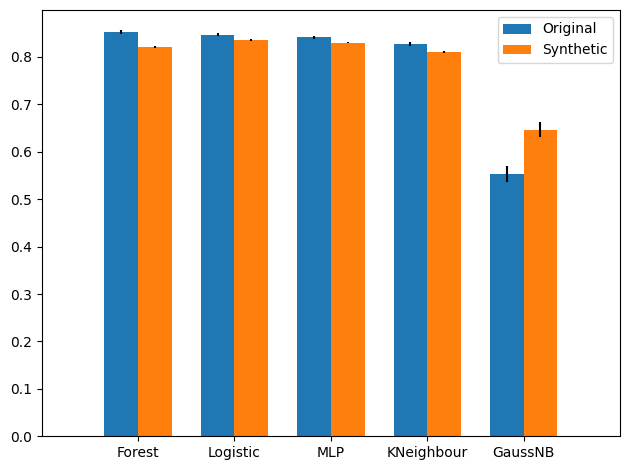

[3 0 2 1 4] ['Logistic' 'KNeighbour' 'MLP' 'Forest' 'GaussNB']


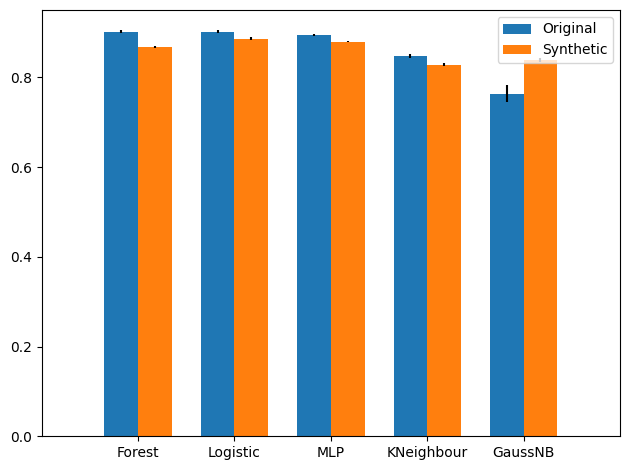

In [7]:
data_train_x = data_train[:, :-2]
data_train_y = np.argmax(data_train[:, -2:], axis=1)
data_test_x = data_test[:, :-2]
data_test_y = np.argmax(data_test[:, -2:], axis=1)

syn_data_train_x = data_train_s[:, :-2]
syn_data_train_y = np.argmax(data_train_s[:, -2:], axis=1)


s = predictive_model_comparison(data_train_x, data_train_y, syn_data_train_x, syn_data_train_y)

# OneClass

In [24]:
import numpy as np
import sys
from sklearn.neighbors import NearestNeighbors
import OneClass

In [25]:
def embed_data_numpy(data, embedding):
    return embedding(torch.tensor(data).float()).float().detach().numpy()
    
def compute_beta_recall_OC(real_data, synthetic_data, real_embedding, synthetic_embedding):
    
    n_steps         = 30
    alphas          = np.linspace(0, 1, n_steps)
    
    # find the centers of the hyperspheres
    
    real_emb_center = torch.tensor(real_embedding.c, device=device)
    
    if synthetic_embedding is not None:
    
        synth_emb_center   = torch.tensor(synthetic_embedding.c, device=device)
        
    # embedd real and synthetic data    
    
    real_data_real_embed   = embed_data_numpy(real_data, real_embedding)
    real_data_synth_embed  = embed_data_numpy(real_data, synthetic_embedding)
    synth_data_real_embed  = embed_data_numpy(synthetic_data, real_embedding)
    synth_data_synth_embed = embed_data_numpy(synthetic_data, synthetic_embedding)
    
    # evaluate real and synthetic radii within the hyperspheres

    real_Radii  = np.quantile(torch.sqrt(torch.sum((torch.tensor(real_data_real_embed).float() - real_emb_center) ** 2, dim=1)), alphas)
    synth_Radii = np.quantile(torch.sqrt(torch.sum((torch.tensor(synth_data_synth_embed).float() - synth_emb_center) ** 2, dim=1)), alphas)
    
    synth_to_real_center = torch.sqrt(torch.sum((torch.tensor(synth_data_real_embed).float() - real_emb_center) ** 2, dim=1))
    real_to_synth_center = torch.sqrt(torch.sum((torch.tensor(real_data_synth_embed).float() - synth_emb_center) ** 2, dim=1))
    
    # evaluate the precision and recall curves
    beta_recall_curve    = []
    
    for k in range(len(real_Radii)):
        

        recall_audit_mask    = (real_to_synth_center <= synth_Radii[k]).detach().float().numpy()
        beta_recall          = np.mean(recall_audit_mask)        
        
        beta_recall_curve.append(beta_recall)

    
    return alphas, beta_recall_curve


In [1]:
import theano

ModuleNotFoundError: No module named 'theano'

In [30]:
# OC parameters

params  = {
    "rep_dim": None, 
    "num_layers": 4, 
    "num_hidden": 32, 
    "activation": "ReLU",
    "dropout_prob": 0.2, 
    "dropout_active": False,
    "LossFn": "SoftBoundary",
    "lr": 2e-3,
    "epochs": 1000,
    "warm_up_epochs" : 20,
    "train_prop" : 1.0,
    "weight_decay": 2e-3
}   

hyperparams = {
    "Radius": 1, 
    "nu": 1e-2
}


def compute_metrics(X, Y, embed_synthetic=False):
       
    params["input_dim"]   = X.shape[1]
    params["rep_dim"]     = X.shape[1]        
    hyperparams["center"] = torch.ones(X.shape[1])
        
    real_embedding        = OneClass.OneClassLayer(params=params, hyperparams=hyperparams)
    real_embedding.fit(X, verbosity=False)
        
    if embed_synthetic:   
        
        hyperparams["center"] = torch.ones(X.shape[1]) #torch.tensor(np.mean(Y, axis=0)) #* 
        synthetic_embedding   = OneClass.OneClassLayer(params=params, hyperparams=hyperparams)
        synthetic_embedding.fit(Y, verbosity=False)
        
    else:
        synthetic_embedding = None
    
    if embed_synthetic:
        
        alphas, beta_recall_curve = compute_beta_recall_OC(X, Y, real_embedding, synthetic_embedding)
         
    return alphas, beta_recall_curve

In [32]:
model = OneClass.OneClassLayer(params=params, hyperparams=hyperparams)
model

KeyError: 'input_dim'

In [8]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
device = 'cpu' # matrices are too big for gpu
def compute_alpha_precision(real_data, synthetic_data, emb_center):
    

    emb_center = torch.tensor(emb_center, device=device)

    n_steps = 30
    nn_size = 2
    alphas  = np.linspace(0, 1, n_steps)
        
    
    Radii   = np.quantile(torch.sqrt(torch.sum((torch.tensor(real_data).float() - emb_center) ** 2, dim=1)), alphas)
    
    synth_center          = torch.tensor(np.mean(synthetic_data, axis=0)).float()
    
    alpha_precision_curve = []
    beta_coverage_curve   = []
    
    synth_to_center       = torch.sqrt(torch.sum((torch.tensor(synthetic_data).float() - emb_center) ** 2, dim=1))
    
    
    nbrs_real = NearestNeighbors(n_neighbors = 2, n_jobs=-1, p=2).fit(real_data)
    real_to_real, _       = nbrs_real.kneighbors(real_data)
    
    nbrs_synth = NearestNeighbors(n_neighbors = 1, n_jobs=-1, p=2).fit(synthetic_data)
    real_to_synth, real_to_synth_args = nbrs_synth.kneighbors(real_data)

    # Let us find closest real point to any real point, excluding itself (therefore 1 instead of 0)
    real_to_real          = torch.from_numpy(real_to_real[:,1].squeeze())
    real_to_synth         = torch.from_numpy(real_to_synth.squeeze())
    real_to_synth_args    = real_to_synth_args.squeeze()

    real_synth_closest    = synthetic_data[real_to_synth_args]
    
    real_synth_closest_d  = torch.sqrt(torch.sum((torch.tensor(real_synth_closest).float()- synth_center) ** 2, dim=1))
    closest_synth_Radii   = np.quantile(real_synth_closest_d, alphas)


    
    for k in range(len(Radii)):
        precision_audit_mask = (synth_to_center <= Radii[k]).detach().float().numpy()
        alpha_precision      = np.mean(precision_audit_mask)

        beta_coverage        = np.mean(((real_to_synth <= real_to_real) * (real_synth_closest_d <= closest_synth_Radii[k])).detach().float().numpy())
 
        alpha_precision_curve.append(alpha_precision)
        beta_coverage_curve.append(beta_coverage)
    

    # See which one is bigger
    
    authen = real_to_real[real_to_synth_args] < real_to_synth
    authenticity = np.mean(authen.numpy())

    Delta_precision_alpha = 1 - 2 * np.sum(np.abs(np.array(alphas) - np.array(alpha_precision_curve))) * (alphas[1] - alphas[0])
    Delta_coverage_beta  = 1 - 2 * np.sum(np.abs(np.array(alphas) - np.array(beta_coverage_curve))) * (alphas[1] - alphas[0])
    
    return alphas, alpha_precision_curve, beta_coverage_curve, Delta_precision_alpha, Delta_coverage_beta, authenticity